In [2]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from copy import copy
import re

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import shap

import utils.DataSplitter
import utils.Sklearn
from utils.metrics import *
from utils.ColumnEnum import Columns

import warnings

warnings.filterwarnings('ignore', category=UserWarning)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
level = 60
line = Columns.line_1A.value
target = Columns.target_passengersBoarding.value

if level == 60:
    agg = 1
elif level == 30:
    agg = 2
elif level == 15:
    agg = 4

df_level = utils.DataSplitter.getTrainData(agglevel=level, diff=False)
df_level_line = df_level[df_level['line'] == line]
df_train, df_val = utils.DataSplitter.performTrainValSplit(df=df_level_line)

to_drop = [target]
X_train = utils.DataSplitter.subsetColumns(df_train, dropCategorical=True, dropLags=True, dropWeather=False, dropCalendar=False, 
                                           dropSpecific=to_drop)
y_train = df_train[target]

X_val = utils.DataSplitter.subsetColumns(df_val, dropCategorical=True, dropLags=True, dropWeather=False, dropCalendar=False, 
                                         dropSpecific=to_drop)
y_val = df_val[target]

print(all(X_train.columns == X_val.columns))
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)
print(X_train.columns)

True
(14680, 29) (14680,) (1840, 29) (1840,)
Index(['peakHour', 'Q1', 'Q2', 'Q3', 'Q4', 'mon', 'tue', 'wed', 'thu', 'fri',
       'sat', 'sun', 'workdayPlan', 'saturdayPlan', 'sundayAndHolidayPlan',
       'summerVacation', 'fallVacation', 'christmasVacation', 'winterVacation',
       'easterVacation', 'acc_precip', 'bright_sunshine', 'mean_cloud_cover',
       'mean_pressure', 'mean_relative_hum', 'mean_temp', 'mean_wind_speed',
       'snow_depth', 'event'],
      dtype='object')


In [3]:
# for testing
level = 60
line = Columns.line_1A.value
target = Columns.target_passengersBoarding.value

if level == 60:
    agg = 1
elif level == 30:
    agg = 2
elif level == 15:
    agg = 4

to_drop = [target]

df_level = utils.DataSplitter.getTrainData(agglevel=level, diff=False)
df_train = df_level[df_level['line'] == line]

X_train = utils.DataSplitter.subsetColumns(df_train, dropCategorical=True, dropLags=True, dropWeather=False, dropCalendar=False, 
                                           dropSpecific=to_drop)
y_train = df_train[target]

df_train.index = pd.RangeIndex(start=0, stop=df_train.shape[0])
X_train.index = df_train.index
y_train.index = df_train.index


df_level_test = utils.DataSplitter.getTestData(agglevel=level, diff=False)
df_val = df_level_test[df_level_test['line'] == line]

X_val = utils.DataSplitter.subsetColumns(df_val, dropCategorical=True, dropLags=True, dropWeather=False, dropCalendar=False, 
                                           dropSpecific=to_drop)
y_val = df_val[target]

df_val.index = pd.RangeIndex(start = X_train.shape[0], stop = X_train.shape[0] + X_val.shape[0])
X_val.index = df_val.index
y_val.index = df_val.index

print(all(X_train.columns == X_val.columns))
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)
print(X_train.columns)

True
(16520, 29) (16520,) (1840, 29) (1840,)
Index(['peakHour', 'Q1', 'Q2', 'Q3', 'Q4', 'mon', 'tue', 'wed', 'thu', 'fri',
       'sat', 'sun', 'workdayPlan', 'saturdayPlan', 'sundayAndHolidayPlan',
       'summerVacation', 'fallVacation', 'christmasVacation', 'winterVacation',
       'easterVacation', 'acc_precip', 'bright_sunshine', 'mean_cloud_cover',
       'mean_pressure', 'mean_relative_hum', 'mean_temp', 'mean_wind_speed',
       'snow_depth', 'event'],
      dtype='object')


In [4]:
X_train_modified = copy(X_train)
y_train_modified = copy(y_train)
X_val_modified = copy(X_val)
y_val_modified = copy(y_val)

for lag in [20, 40, 60, 80, 100, 120, 140]:
    X_train_modified[f'{lag}'] = y_train_modified.shift(periods=lag).fillna(0)
    X_val_modified[f'{lag}'] = y_val_modified.shift(periods=lag).fillna(0)

# Anatomy

In [5]:
import os
from anatomy import *

from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

def generate_data(n_predictors=3) -> [pd.DataFrame, AnatomySubsets]:
    xy = copy(pd.concat([X_train, X_val]))
    scalar = StandardScaler()
    xy = pd.DataFrame(scalar.fit_transform(xy), columns=xy.columns)

    xy['y'] = copy(pd.concat([y_train, y_val]))
    for i in [20, 40, 60, 80, 100, 120, 140]:
        xy[f'{i}'] = xy['y'].shift(periods=i).fillna(0)

    subsets = AnatomySubsets.generate(
        index=xy.index,
        initial_window=X_train.shape[0],
        estimation_type=AnatomySubsets.EstimationType.EXPANDING,
        periods=1,
        gap=0
    )

    return xy, subsets

## Lasso test

In [5]:
def anatomize(xy: pd.DataFrame, subsets: AnatomySubsets) -> None:
    anatomy = Anatomy.load("anatomyLassotest.bin")
    groups = {
        "lasso": ["lasso"]
    }

    def anatomize_mae() -> pd.DataFrame:
        def transform(y_hat, y):
            return nMAE(y=y, yhat=y_hat)

        return anatomy.explain(
            model_sets=AnatomyModelCombination(groups=groups),
            transformer=AnatomyModelOutputTransformer(transform=transform)
        )

    anatomized_mae = anatomize_mae()
    return anatomized_mae

np.random.seed(42)
xy, subsets = generate_data()
print('data generated')

anatomized_mae_lasso = anatomize(xy, subsets)

data generated


### PBSV

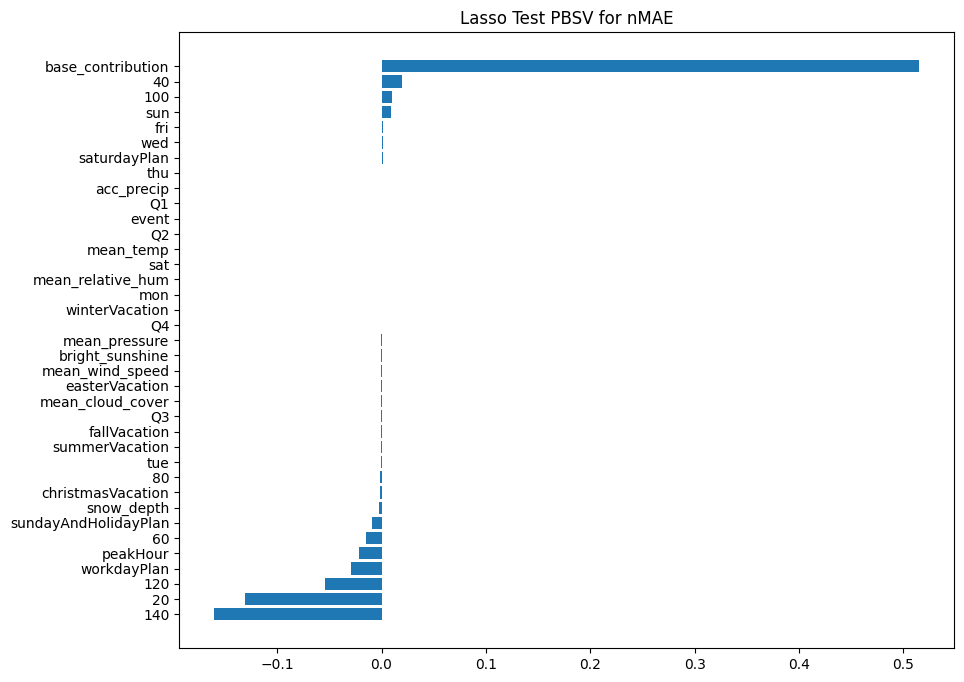

In [7]:
keys = anatomized_mae_lasso.transpose()['lasso']['16520 -> 18359'].index
values = anatomized_mae_lasso.transpose()['lasso']['16520 -> 18359'].to_list()
shapley_dict = dict(map(lambda i,j : (i,j), keys, values))

utils.tools.plotFeatureImportance(shapley_dict, 'Lasso Test PBSV for nMAE')

## Random Forest test

In [8]:
def anatomize(xy: pd.DataFrame, subsets: AnatomySubsets) -> None:
    anatomy = Anatomy.load("anatomyRFtest.bin")
    groups = {
        "rf": ["rf"]
    }

    def anatomize_mae() -> pd.DataFrame:
        def transform(y_hat, y):
            return nMAE(y=y, yhat=y_hat)

        return anatomy.explain(
            model_sets=AnatomyModelCombination(groups=groups),
            transformer=AnatomyModelOutputTransformer(transform=transform)
        )

    anatomized_mae = anatomize_mae()
    return anatomized_mae

np.random.seed(42)
xy, subsets = generate_data()
print('data generated')

anatomized_mae_rf = anatomize(xy, subsets)

data generated


### PBSV

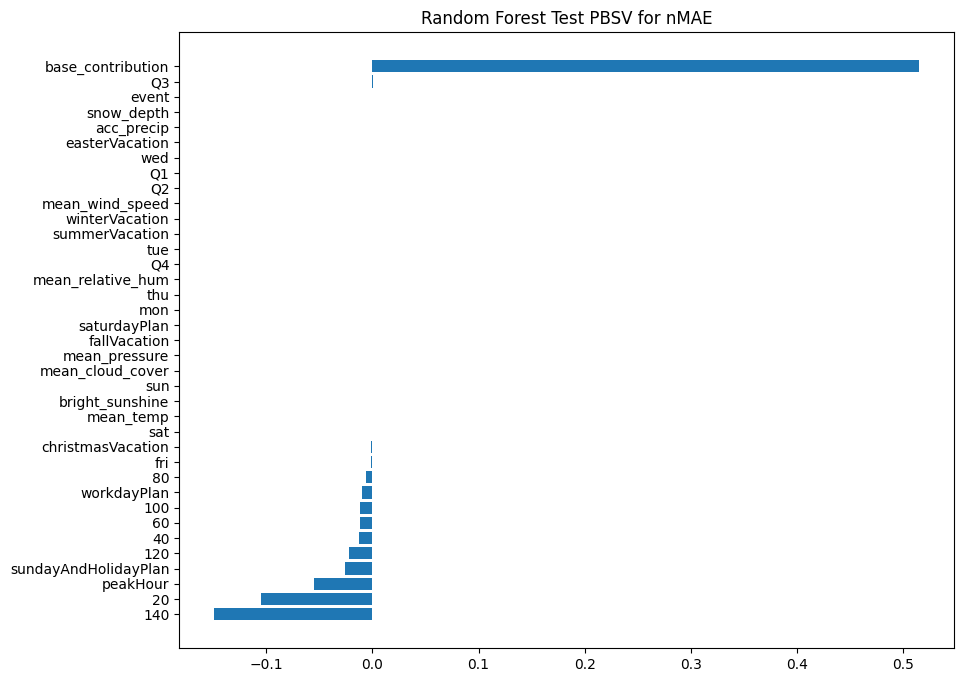

In [9]:
keys = anatomized_mae_rf.transpose()['rf']['16520 -> 18359'].index
values = anatomized_mae_rf.transpose()['rf']['16520 -> 18359'].to_list()
shapley_dict = dict(map(lambda i,j : (i,j), keys, values))

utils.tools.plotFeatureImportance(shapley_dict, 'Random Forest Test PBSV for nMAE')

## XGBoost test

In [8]:
def anatomize(xy: pd.DataFrame, subsets: AnatomySubsets) -> None:
    anatomy = Anatomy.load("anatomyXGBtest.bin")
    groups = {
        "xgb": ["xgb"]
    }

    def anatomize_mae() -> pd.DataFrame:
        def transform(y_hat, y):
            return nMAE(y=y, yhat=y_hat)

        return anatomy.explain(
            model_sets=AnatomyModelCombination(groups=groups),
            transformer=AnatomyModelOutputTransformer(transform=transform)
        )
    
    def anatomize_raw() -> pd.DataFrame:
        def transform(y_hat):
            return y_hat

        return anatomy.explain(
            model_sets=AnatomyModelCombination(groups=groups),
            transformer=AnatomyModelOutputTransformer(transform=transform)
        )

    anatomized_mae = anatomize_mae()
    anatomized_raw = anatomize_raw()
    return anatomized_raw, anatomized_mae

np.random.seed(42)
xy, subsets = generate_data()
print('data generated')

anatomized_raw_xgb, anatomized_mae_xgb = anatomize(xy, subsets)

data generated


### PBSV

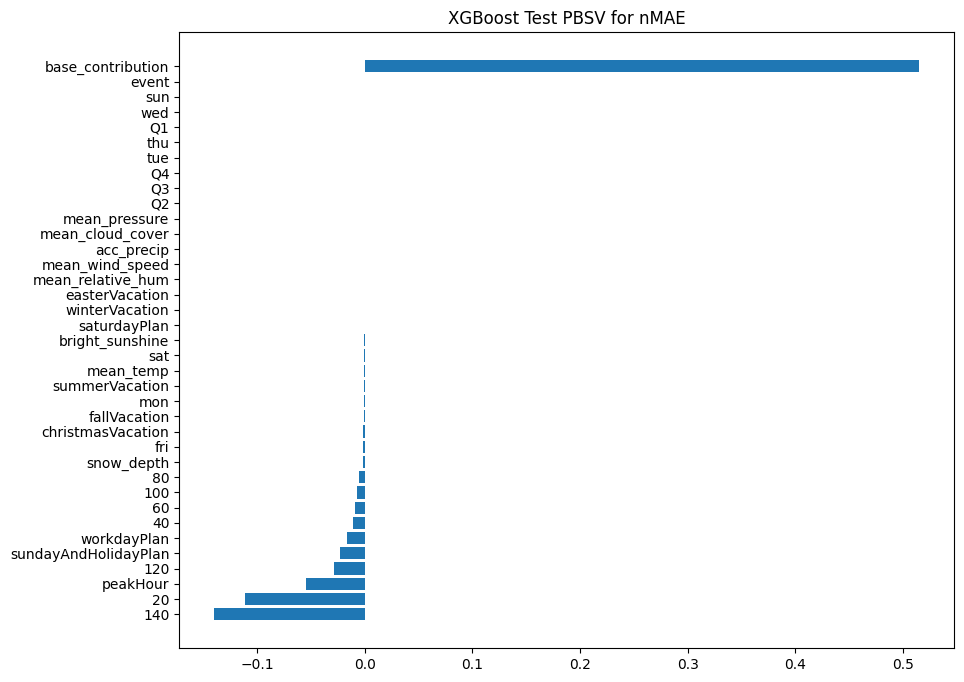

In [9]:
keys = anatomized_mae_xgb.transpose()['xgb']['16520 -> 18359'].index
values = anatomized_mae_xgb.transpose()['xgb']['16520 -> 18359'].to_list()
shapley_dict = dict(map(lambda i,j : (i,j), keys, values))

utils.tools.plotFeatureImportance(shapley_dict, 'XGBoost Test PBSV for nMAE')

### oShapley-VI

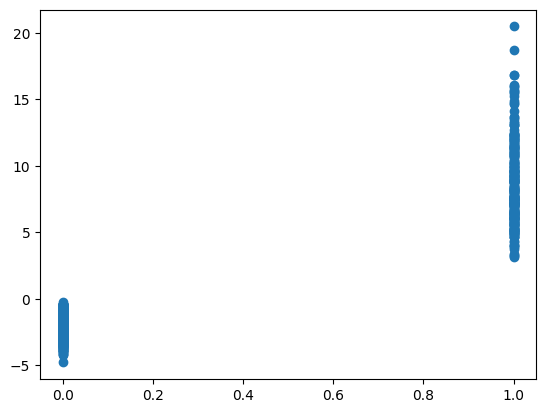

0   -1.453698
1    8.686248
Name: saturdayPlan, dtype: float64

In [46]:
variable = Columns.calendar_saturdayPlan
keys = anatomized_raw_xgb.loc['xgb'].index
values = anatomized_raw_xgb.loc['xgb'][variable.value]

plt.scatter(df_val[df_val['line'] == '1A'][variable.value].values, values)
plt.show()

values.groupby(df_val[df_val['line'] == '1A'][variable.value].values).mean()

<Axes: >

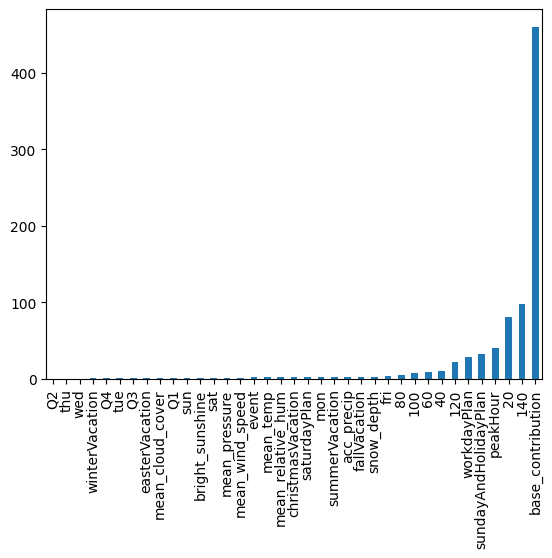

In [95]:
anatomized_raw_xgb.abs().mean(axis=0).sort_values().plot(kind='bar')

In [96]:
# ordinary shap
model = XGBRegressor(n_estimators=100, eta=0.3, alpha=0.1)
model.fit(X_train_modified, y_train_modified)
explainer = shap.Explainer(model.predict, X_val_modified)
explanation = explainer(X_val_modified)
shap_values = explanation.values

PermutationExplainer explainer: 1841it [00:44, 32.29it/s]                          


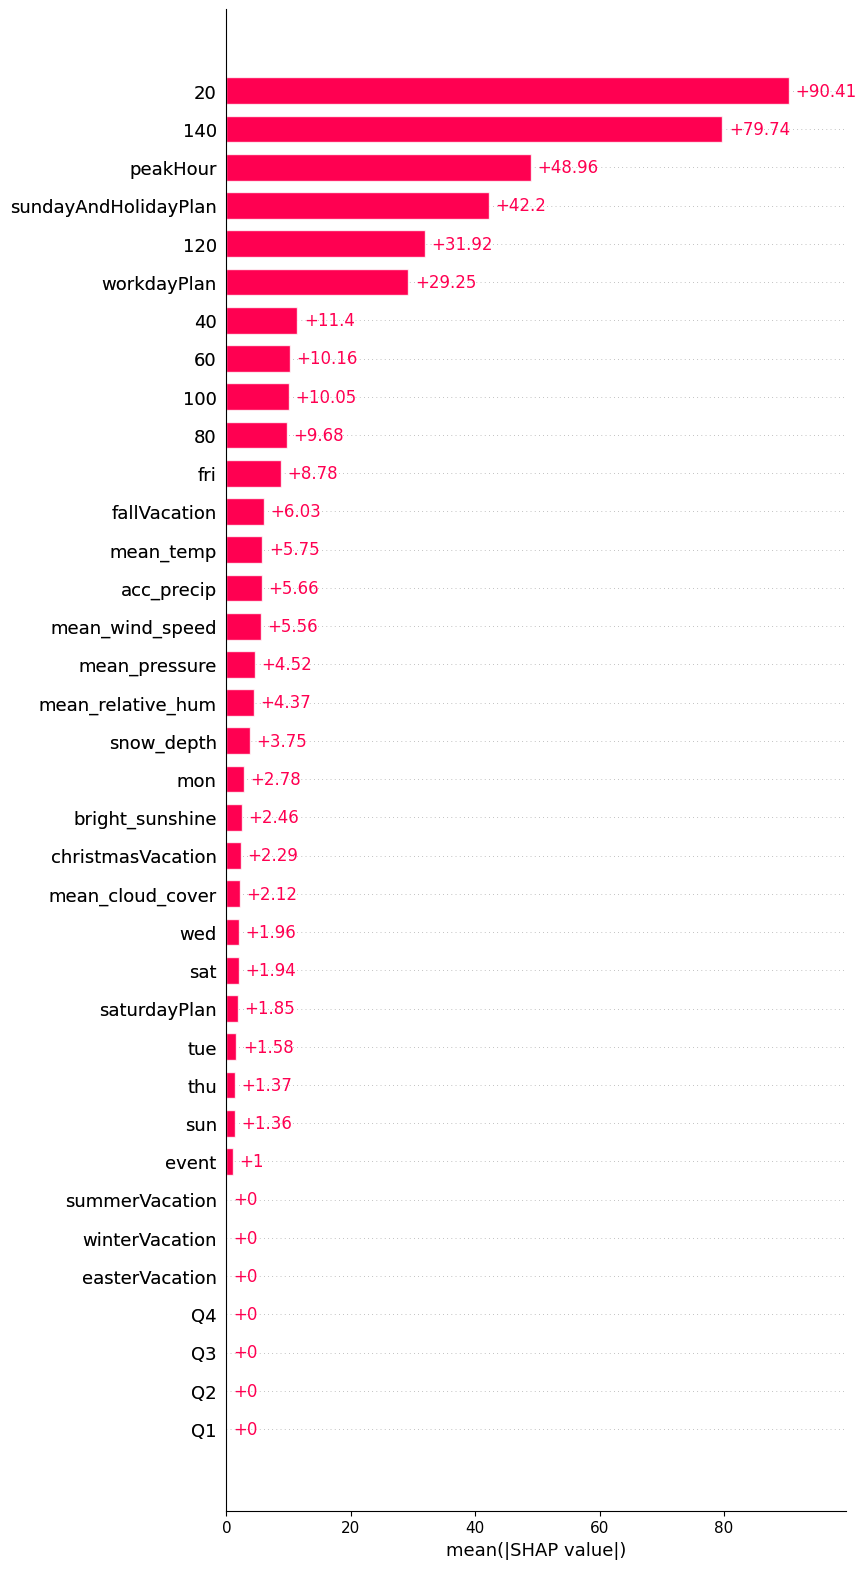

In [97]:
shap.plots.bar(explanation, max_display=36)